Setting up image transformations for training and testing...
Image transformations are ready.
Defining custom dataset class for wheat disease images...
Custom dataset class defined.
Preparing data loaders and splitting dataset if needed...
Loading data...
Found existing split dataset. Loading splits...
Calculating class weights for balanced sampling...
Data loaders are ready.
Data loaded. Classes: ['aphid', 'army_worm', 'black_rust', 'brown_rust', 'common_rust', 'fusarium_head_blight', 'healthy', 'leaf_blight', 'powdery_mildew_leaf', 'spetoria', 'tan_spot', 'yellow_rust']
Initializing model...
Using device: cpu


c:\Users\Sqli4\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sqli4\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No SimCLR pre-trained weights found. Training from scratch.
Model initialized. Starting training...


C:\Users\Sqli4\AppData\Local\Temp\ipykernel_7696\2323827596.py:148: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
C:\Users\Sqli4\AppData\Local\Temp\ipykernel_7696\2323827596.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
C:\Users\Sqli4\AppData\Local\Temp\ipykernel_7696\2323827596.py:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):


Epoch 1/10 | Train Loss: 1.3262 Acc: 0.4397 | Val Loss: 0.7934 Acc: 0.6426 | LR: 0.000100 | Time: 301.9s
Epoch 2/10 | Train Loss: 0.7130 Acc: 0.6333 | Val Loss: 0.5624 Acc: 0.7278 | LR: 0.000100 | Time: 356.9s
Epoch 3/10 | Train Loss: 0.5324 Acc: 0.7095 | Val Loss: 0.4984 Acc: 0.7259 | LR: 0.000100 | Time: 357.5s
Epoch 4/10 | Train Loss: 0.4510 Acc: 0.7448 | Val Loss: 0.4432 Acc: 0.7426 | LR: 0.000100 | Time: 368.8s
Epoch 5/10 | Train Loss: 0.3970 Acc: 0.7726 | Val Loss: 0.4149 Acc: 0.7500 | LR: 0.000100 | Time: 352.7s
Epoch 6/10 | Train Loss: 0.3353 Acc: 0.7976 | Val Loss: 0.3912 Acc: 0.7704 | LR: 0.000100 | Time: 355.2s
Epoch 7/10 | Train Loss: 0.3278 Acc: 0.7984 | Val Loss: 0.3899 Acc: 0.7852 | LR: 0.000100 | Time: 284.7s
Epoch 8/10 | Train Loss: 0.3053 Acc: 0.8052 | Val Loss: 0.3620 Acc: 0.8019 | LR: 0.000100 | Time: 353.4s
Epoch 9/10 | Train Loss: 0.2517 Acc: 0.8389 | Val Loss: 0.3519 Acc: 0.8111 | LR: 0.000100 | Time: 349.8s
Epoch 10/10 | Train Loss: 0.2448 Acc: 0.8425 | Val Loss

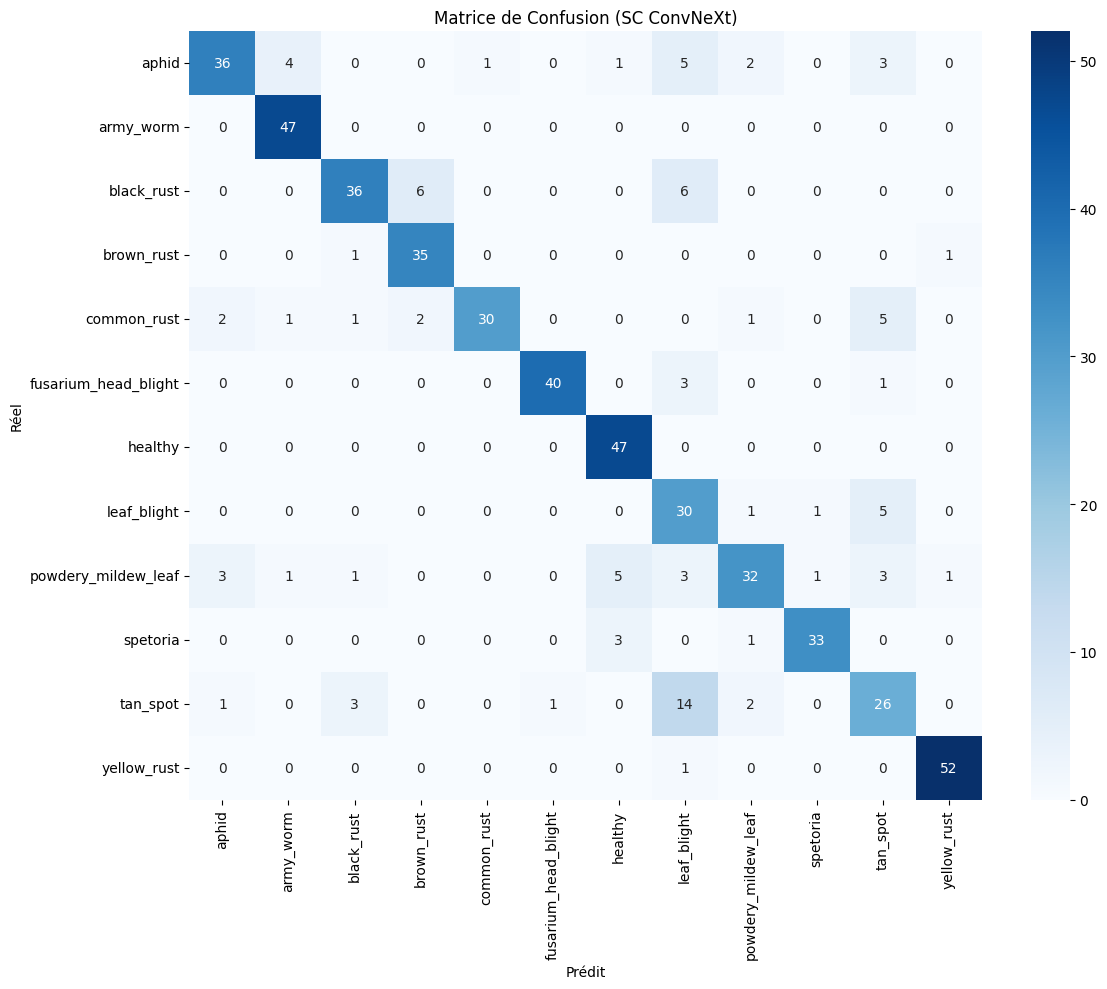


Rapport de classification:
                      precision    recall  f1-score   support

               aphid     0.8571    0.6923    0.7660        52
           army_worm     0.8868    1.0000    0.9400        47
          black_rust     0.8571    0.7500    0.8000        48
          brown_rust     0.8140    0.9459    0.8750        37
         common_rust     0.9677    0.7143    0.8219        42
fusarium_head_blight     0.9756    0.9091    0.9412        44
             healthy     0.8393    1.0000    0.9126        47
         leaf_blight     0.4839    0.8108    0.6061        37
 powdery_mildew_leaf     0.8205    0.6400    0.7191        50
            spetoria     0.9429    0.8919    0.9167        37
            tan_spot     0.6047    0.5532    0.5778        47
         yellow_rust     0.9630    0.9811    0.9720        53

            accuracy                         0.8207       541
           macro avg     0.8344    0.8241    0.8207       541
        weighted avg     0.8388    0.820

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
import time
from sc_convnext_model import SCConvNeXt, FocalLoss

# -----------------------------
# Configuration
# -----------------------------
DATASET_DIR = '../dataset'
SAVE_DIR = '../saved_models_and_data'
SPLIT_OUTPUT_DIR = '../dataset_split'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
TEST_SIZE = 0.15
VAL_SIZE = 0.15
EPOCHS = 10
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 5
USE_MIXED_PRECISION = True if torch.cuda.is_available() else False

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(SPLIT_OUTPUT_DIR, exist_ok=True)

print('Setting up image transformations for training and testing...')
# -----------------------------
# Transformations
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
print('Image transformations are ready.')

print('Defining custom dataset class for wheat disease images...')
# -----------------------------
# Custom Dataset
# -----------------------------
class WheatDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for target_class in self.classes:
            class_dir = os.path.join(root_dir, target_class)
            for img_file in os.listdir(class_dir):
                path = os.path.join(class_dir, img_file)
                self.samples.append((path, self.class_to_idx[target_class]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        try:
            image = Image.open(path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, target
        except Exception as e:
            print(f"Erreur lors du chargement de {path}: {e}")
            return self.__getitem__((idx + 1) % len(self))
print('Custom dataset class defined.')

print('Preparing data loaders and splitting dataset if needed...')
# -----------------------------
# Load and Split Dataset
# -----------------------------
def get_data_loaders():
    split_dirs = [os.path.join(SPLIT_OUTPUT_DIR, split) for split in ['train', 'val', 'test']]
    split_exists = all(os.path.isdir(d) and len(os.listdir(d)) > 0 for d in split_dirs)
    if split_exists:
        print('Found existing split dataset. Loading splits...')
        train_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'train'), transform=train_transform)
        val_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'val'), transform=test_transform)
        test_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'test'), transform=test_transform)
    else:
        print('No split dataset found. Splitting and saving images...')
        full_dataset = WheatDiseaseDataset(DATASET_DIR, transform=train_transform)
        generator = torch.Generator().manual_seed(42)
        indices = torch.randperm(len(full_dataset), generator=generator).tolist()
        train_size = int((1 - TEST_SIZE - VAL_SIZE) * len(full_dataset))
        val_size = int(VAL_SIZE * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        train_indices = indices[:train_size]
        val_indices = indices[train_size:train_size + val_size]
        test_indices = indices[train_size + val_size:]
        train_data = Subset(full_dataset, train_indices)
        val_data = Subset(full_dataset, val_indices)
        test_data = Subset(full_dataset, test_indices)
        def save_split_images(dataset, indices, split_name):
            print(f"Saving images for split: {split_name}")
            for idx in indices:
                path, label_idx = dataset.dataset.samples[idx]  # dataset is a Subset
                class_name = dataset.dataset.classes[label_idx]
                filename = os.path.basename(path)
                dest_dir = os.path.join(SPLIT_OUTPUT_DIR, split_name, class_name)
                os.makedirs(dest_dir, exist_ok=True)
                dest_path = os.path.join(dest_dir, filename)
                shutil.copyfile(path, dest_path)
        save_split_images(train_data, train_indices, 'train')
        save_split_images(val_data, val_indices, 'val')
        save_split_images(test_data, test_indices, 'test')
        print('Image splits saved.')
        train_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'train'), transform=train_transform)
        val_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'val'), transform=test_transform)
        test_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'test'), transform=test_transform)
    print('Calculating class weights for balanced sampling...')
    targets = [s[1] for s in train_dataset.samples]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[t] for t in targets]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print('Data loaders are ready.')
    return train_loader, val_loader, test_loader, train_dataset.classes

# -----------------------------
# Training Function with Optimizations
# -----------------------------
def train_model(model, device, train_loader, val_loader, num_epochs=EPOCHS):
    criterion = FocalLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    best_acc = 0.0
    no_improvement_epochs = 0
    scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
    train_log = []
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True  # optimize for speed
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | LR: {current_lr:.6f} | Time: {time.time()-start_time:.1f}s")
        train_log.append({'epoch': epoch+1, 'train_loss': epoch_loss, 'train_acc': epoch_acc.item(), 'val_loss': val_loss, 'val_acc': val_acc.item(), 'lr': current_lr})
        # Early Stopping
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_sc_convnext_model.pth"))
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
        if no_improvement_epochs >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break
    print("Entraînement terminé.")
    return model, train_log

# -----------------------------
# Model Loader Function & Optimizations
# -----------------------------
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def load_model(num_classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = SCConvNeXt(num_classes=num_classes)
    simclr_weights = 'saved_models_and_data/simclr_convnext_tiny.pth'
    if os.path.exists(simclr_weights):
        print(f"Loading SimCLR pre-trained weights from {simclr_weights}")
        model.load_simclr_weights(simclr_weights)
    else:
        print("No SimCLR pre-trained weights found. Training from scratch.")
    model = model.to(device)
    return model, device

# Optionally, print CUDA info for debugging
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    print('Loading data...')
    train_loader, val_loader, test_loader, class_labels = get_data_loaders()
    print('Data loaded. Classes:', class_labels)
    print('Initializing model...')
    try:
        model, device = load_model(len(class_labels))
    except NotImplementedError as e:
        print(e)
        exit(1)
    print('Model initialized. Starting training...')
    model, train_log = train_model(model, device, train_loader, val_loader)
    print('Training complete. Evaluating on test set...')
    # Evaluation on Test Set
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_sc_convnext_model.pth"), map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print('Test set predictions complete. Generating confusion matrix...')
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title("Matrice de Confusion (SC ConvNeXt)")
    plt.tight_layout()
    plt.show()
    print("\nRapport de classification:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, "wheat_disease_sc_convnext_model.pth"))
    print('Model saved to', os.path.join(SAVE_DIR, "wheat_disease_sc_convnext_model.pth")) 